# Imports

In [1]:
# Suprress warnings
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Standard imports
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import matplotlib.cm as cm
    import numpy as np

    # Drake imports
    from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
    import pydrake
    from pydrake.all import LogOutput, DirectCollocation, DirectTranscription, MathematicalProgram, InputPortSelection
    from pydrake.all import FindResourceOrThrow
    
    import scipy.interpolate

# Imports of other project files
from log_wrapper import LogWrapper
import controller
import constants

from plant.paper import Paper
import plant.pedestal as pedestal
import plant.manipulator as manipulator

import perception.vision as vision
import perception.proprioception as proprioception

import ctrl.common
import ctrl.aux
import ctrl.inverse_dynamics

from pydrake.all import (MultibodyPlant, Parser, DiagramBuilder, Simulator, RigidTransform,
                         PlanarSceneGraphVisualizer, SceneGraph, TrajectorySource,
                         SnoptSolver, MultibodyPositionToGeometryPose, PiecewisePolynomial,
                         MathematicalProgram, JacobianWrtVariable, eq, RollPitchYaw, AutoDiffXd, BodyIndex,
                        RotationMatrix, Meshcat,MeshcatVisualizerParams, MeshcatVisualizerCpp, MeshcatVisualizer,
                        Adder, Gain)

# Other imports
import importlib
import re

In [2]:
from IPython.display import display, SVG
import pydot

In [3]:
# Matplotlib configuring
# USE FOR PAPER
# plt.style.use(['science', 'no-latex'])
# font = {'size'   : 14}
# matplotlib.rc('font', **font)
# default_figsize = (2*3,2*2)
# USE GENERALLY
font = {'size'   : 16}
matplotlib.rc('font', **font)
default_figsize = (16,8)

## Meshcat init (including link for new meshcat)

In [4]:
if constants.USE_NEW_MESHCAT:
    meshcat = Meshcat()
    web_url = meshcat.web_url()
else:
    proc, zmq_url, web_url = start_zmq_server_as_subprocess()

# Simulation setup
## Pre-finalize steps

In [5]:
builder = pydrake.systems.framework.DiagramBuilder()

manipulator_acc_log = []
manipulator_acc_log.append(np.zeros(7))

# Add all elements
plant, scene_graph = pydrake.multibody.plant.AddMultibodyPlantSceneGraph(builder, time_step=constants.DT)
v_stiction=1e-3
plant.set_stiction_tolerance(v_stiction)
plant.set_penetration_allowance(0.001)
pedestal_instance = pedestal.AddPedestal(plant)

# These joint angles start the paper approximately the right spot, no matter how many links are used
num_links = 2
def_joint_angles = 0

paper = Paper(plant, scene_graph, num_links, default_joint_angle=def_joint_angles,
              stiffness=2.5e-1,
              damping=1e-1)
paper.weld_paper_edge(pedestal.PEDESTAL_WIDTH, pedestal.PEDESTAL_HEIGHT)

Calculate link inertia to use in damping calculations:

In [6]:
manipulator_instance = manipulator.data["add_plant_function"](plant, scene_graph)

In [7]:
# Set up logger (needs to happen after all bodies are added)
contact_body = plant.GetBodyByName(manipulator.data["contact_body_name"])
log_wrapper = LogWrapper(plant.num_bodies(), int(contact_body.index()), paper)
builder.AddSystem(log_wrapper)

## Controller selection

In [8]:
ll_idx = paper.link_idxs[-1]
contact_body_idx = int(contact_body.index())

In [9]:
I_L = plant.get_body(
    BodyIndex(paper.link_idxs[-1])).default_rotational_inertia().CalcPrincipalMomentsOfInertia()[0]
sys_params = {
    'I_L': I_L,
    'v_stiction': v_stiction,
    'w_L': paper.link_width,
    'm_L': paper.link_mass,
    'm_M': manipulator.MASS,
    'b_J': paper.damping,
    'k_J': paper.stiffness,
    'g': plant.gravity_field().gravity_vector()[-1]*-1,
}
# fold_ctrl = controller.FoldingInverseDynamicsController(
#     ll_idx=int(paper.link_idxs[-1]),
#     contact_body_idx=contact_body_idx,
#     sys_params=sys_params,
#     options={
#         'model_friction': True,
#         'measure_joint_wrench': False,
#     },
# )

In [10]:
sys_consts = ctrl.common.SystemConstants
sys_consts.I_L = I_L
sys_consts.v_stiction = v_stiction
sys_consts.w_L = paper.link_width
sys_consts.h_L = paper.height
sys_consts.m_L = paper.link_mass
sys_consts.m_M = manipulator.MASS
sys_consts.b_J = paper.damping
sys_consts.k_J = paper.stiffness
sys_consts.g = plant.gravity_field().gravity_vector()[-1]*-1
sys_consts.r =  manipulator.RADIUS
mu_paper = constants.FRICTION
sys_consts.mu = 2*mu_paper/(1+mu_paper)

options={
        'model_friction': True,
        'measure_joint_wrench': False,
    }

## Other pre-finalize step

In [11]:
vision_processor = vision.VisionProcessor(sys_params)
builder.AddSystem(vision_processor)
vision = vision.VisionSystem(ll_idx=ll_idx, contact_body_idx=contact_body_idx)
builder.AddSystem(vision)

In [12]:
proprioception = proprioception.ProprioceptionSystem()
builder.AddSystem(proprioception)

In [13]:
adder = Adder(3, manipulator.data['nq'])
builder.AddSystem(adder)
tau_g_gain = Gain(-1, manipulator.data['nq'])
builder.AddSystem(tau_g_gain)

<pydrake.systems.primitives.Gain_[float] at 0x18351c7b0>

In [14]:
joint_centering_ctrl = ctrl.aux.JointCenteringCtrl()
builder.AddSystem(joint_centering_ctrl)

In [15]:
pre_contact_ctrl = ctrl.aux.PreContactCtrl()
builder.AddSystem(pre_contact_ctrl)

In [16]:
inverse_dynamics_ctrl = ctrl.inverse_dynamics.InverseDynamicsController(sys_consts=sys_consts, options=options)
builder.AddSystem(inverse_dynamics_ctrl)

In [17]:
ctrl_selector = ctrl.aux.CtrlSelector()
builder.AddSystem(ctrl_selector)

## Post-finalize steps

In [18]:
plant.Finalize()

In [19]:
# Set up vision
builder.Connect(plant.get_body_poses_output_port(), vision.GetInputPort("poses"))
builder.Connect(plant.get_body_spatial_velocities_output_port(), vision.GetInputPort("vels"))

# Set up vision processor
builder.Connect(vision.GetOutputPort("pose_L_translational"), vision_processor.GetInputPort("pose_L_translational"))
builder.Connect(vision.GetOutputPort("pose_L_rotational"), vision_processor.GetInputPort("pose_L_rotational"))
builder.Connect(vision.GetOutputPort("vel_L_translational"), vision_processor.GetInputPort("vel_L_translational"))
builder.Connect(vision.GetOutputPort("vel_L_rotational"), vision_processor.GetInputPort("vel_L_rotational"))
builder.Connect(vision.GetOutputPort("pose_M_translational"), vision_processor.GetInputPort("pose_M_translational"))
builder.Connect(vision.GetOutputPort("pose_M_rotational"), vision_processor.GetInputPort("pose_M_rotational"))
builder.Connect(vision.GetOutputPort("vel_M_translational"), vision_processor.GetInputPort("vel_M_translational"))
builder.Connect(vision.GetOutputPort("vel_M_rotational"), vision_processor.GetInputPort("vel_M_rotational"))

# Set up proprioception
builder.Connect(plant.get_state_output_port(manipulator_instance), proprioception.GetInputPort("state"))

# Set up logger
builder.Connect(plant.get_body_poses_output_port(), log_wrapper.GetInputPort("poses"))
builder.Connect(plant.get_body_spatial_velocities_output_port(), log_wrapper.GetInputPort("vels"))
builder.Connect(plant.get_body_spatial_accelerations_output_port(), log_wrapper.GetInputPort("accs")) 
builder.Connect(plant.get_contact_results_output_port(), log_wrapper.GetInputPort("contact_results"))
builder.Connect(plant.get_reaction_forces_output_port(), log_wrapper.GetInputPort("joint_forces"))
builder.Connect(plant.get_generalized_acceleration_output_port(manipulator_instance),
                log_wrapper.GetInputPort("manipulator_accs"))
builder.Connect(plant.get_state_output_port(manipulator_instance), log_wrapper.GetInputPort("state"))
builder.Connect(proprioception.GetOutputPort("tau_g"), log_wrapper.GetInputPort("tau_g"))
builder.Connect(proprioception.GetOutputPort("M"), log_wrapper.GetInputPort("M"))
builder.Connect(proprioception.GetOutputPort("Cv"), log_wrapper.GetInputPort("Cv"))
builder.Connect(proprioception.GetOutputPort("J"), log_wrapper.GetInputPort("J"))
builder.Connect(proprioception.GetOutputPort("Jdot_qdot"), log_wrapper.GetInputPort("Jdot_qdot"))
builder.Connect(vision_processor.GetOutputPort("in_contact"), log_wrapper.GetInputPort("in_contact"))

In [20]:
builder.Connect(vision_processor.GetOutputPort("theta_L"), inverse_dynamics_ctrl.GetInputPort("theta_L"))
builder.Connect(vision_processor.GetOutputPort("d_theta_L"), inverse_dynamics_ctrl.GetInputPort("d_theta_L"))
builder.Connect(vision_processor.GetOutputPort("p_LN"), inverse_dynamics_ctrl.GetInputPort("p_LN"))
builder.Connect(vision_processor.GetOutputPort("p_LT"), inverse_dynamics_ctrl.GetInputPort("p_LT"))
builder.Connect(vision_processor.GetOutputPort("theta_MX"), inverse_dynamics_ctrl.GetInputPort("theta_MX"))
builder.Connect(vision_processor.GetOutputPort("theta_MY"), inverse_dynamics_ctrl.GetInputPort("theta_MY"))
builder.Connect(vision_processor.GetOutputPort("theta_MZ"), inverse_dynamics_ctrl.GetInputPort("theta_MZ"))
builder.Connect(vision_processor.GetOutputPort("d_theta_MX"), inverse_dynamics_ctrl.GetInputPort("d_theta_MX"))
builder.Connect(vision_processor.GetOutputPort("d_theta_MY"), inverse_dynamics_ctrl.GetInputPort("d_theta_MY"))
builder.Connect(vision_processor.GetOutputPort("d_theta_MZ"), inverse_dynamics_ctrl.GetInputPort("d_theta_MZ"))
builder.Connect(vision_processor.GetOutputPort("F_GT"), inverse_dynamics_ctrl.GetInputPort("F_GT"))
builder.Connect(vision_processor.GetOutputPort("F_GN"), inverse_dynamics_ctrl.GetInputPort("F_GN"))
builder.Connect(vision_processor.GetOutputPort("d_X"), inverse_dynamics_ctrl.GetInputPort("d_X"))
builder.Connect(vision_processor.GetOutputPort("d_d_X"), inverse_dynamics_ctrl.GetInputPort("d_d_X"))
builder.Connect(vision_processor.GetOutputPort("d_N"), inverse_dynamics_ctrl.GetInputPort("d_N"))
builder.Connect(vision_processor.GetOutputPort("d_d_N"), inverse_dynamics_ctrl.GetInputPort("d_d_N"))
builder.Connect(vision_processor.GetOutputPort("d_T"), inverse_dynamics_ctrl.GetInputPort("d_T"))
builder.Connect(vision_processor.GetOutputPort("d_d_T"), inverse_dynamics_ctrl.GetInputPort("d_d_T"))
builder.Connect(vision_processor.GetOutputPort("p_CN"), inverse_dynamics_ctrl.GetInputPort("p_CN"))
builder.Connect(vision_processor.GetOutputPort("p_CT"), inverse_dynamics_ctrl.GetInputPort("p_CT"))
builder.Connect(vision_processor.GetOutputPort("p_MConM"), inverse_dynamics_ctrl.GetInputPort("p_MConM"))
builder.Connect(vision_processor.GetOutputPort("mu_S"), inverse_dynamics_ctrl.GetInputPort("mu_S"))
builder.Connect(vision_processor.GetOutputPort("hats_T"), inverse_dynamics_ctrl.GetInputPort("hats_T"))
builder.Connect(vision_processor.GetOutputPort("s_hat_X"), inverse_dynamics_ctrl.GetInputPort("s_hat_X"))
builder.Connect(proprioception.GetOutputPort("tau_g"), inverse_dynamics_ctrl.GetInputPort("tau_g"))
builder.Connect(proprioception.GetOutputPort("M"), inverse_dynamics_ctrl.GetInputPort("M"))
builder.Connect(proprioception.GetOutputPort("Cv"), inverse_dynamics_ctrl.GetInputPort("Cv"))
builder.Connect(proprioception.GetOutputPort("J"), inverse_dynamics_ctrl.GetInputPort("J"))
builder.Connect(proprioception.GetOutputPort("J_translational"), inverse_dynamics_ctrl.GetInputPort("J_translational"))
builder.Connect(proprioception.GetOutputPort("J_rotational"), inverse_dynamics_ctrl.GetInputPort("J_rotational"))
builder.Connect(proprioception.GetOutputPort("Jdot_qdot"), inverse_dynamics_ctrl.GetInputPort("Jdot_qdot"))
builder.Connect(joint_centering_ctrl.get_output_port(), inverse_dynamics_ctrl.GetInputPort("joint_centering_torque"))


In [21]:
# Controller connections
builder.Connect(vision_processor.GetOutputPort("in_contact"), ctrl_selector.GetInputPort("in_contact"))
builder.Connect(inverse_dynamics_ctrl.get_output_port(), ctrl_selector.GetInputPort("pre_contact_ctrl"))
builder.Connect(pre_contact_ctrl.get_output_port(), ctrl_selector.GetInputPort("contact_ctrl"))

builder.Connect(proprioception.GetOutputPort("J"), pre_contact_ctrl.GetInputPort("J"))
builder.Connect(vision_processor.GetOutputPort("v_MN"), pre_contact_ctrl.GetInputPort("v_MN"))
builder.Connect(vision_processor.GetOutputPort("N_hat"), pre_contact_ctrl.GetInputPort("N_hat"))

builder.Connect(proprioception.GetOutputPort("J"), joint_centering_ctrl.GetInputPort("J"))
builder.Connect(proprioception.GetOutputPort("q"), joint_centering_ctrl.GetInputPort("q"))
builder.Connect(proprioception.GetOutputPort("v"), joint_centering_ctrl.GetInputPort("v"))

builder.Connect(proprioception.GetOutputPort("tau_g"), tau_g_gain.get_input_port())

builder.Connect(joint_centering_ctrl.get_output_port(), adder.get_input_port(0))
builder.Connect(ctrl_selector.get_output_port(), adder.get_input_port(1))
builder.Connect(tau_g_gain.get_output_port(), adder.get_input_port(2))

builder.Connect(adder.get_output_port(), plant.get_actuation_input_port())

In [22]:
# Visualization and logging
logger = LogOutput(log_wrapper.get_output_port(), builder)

if constants.USE_NEW_MESHCAT:
    params = MeshcatVisualizerParams()
    vis = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph.get_query_output_port(), meshcat, params)
    fold_ctrl.set_meshcat(meshcat)
else:
    vis = pydrake.systems.meshcat_visualizer.ConnectMeshcatVisualizer(builder, scene_graph)
    # vis.set_planar_viewpoint(camera_position=[1, 0, 0], xmin=-0.3, xmax=0.3, ymin=-0.3, ymax=0.3)

# Build diagram and do actions requiring 
diagram = builder.Build()
diagram_context = diagram.CreateDefaultContext()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Connected to meshcat-server.


## Meschat link for old meschat

## Visualize systems

In [23]:
objects_to_remove = [
    "SignalLogger",
    "LogWrapper",
    "scene_graph",
    "meshcat"
]
viz_str = diagram.GetGraphvizString()
for obj in objects_to_remove:
    expr = r'([0-9]{15}) \[[^\]]*label="[^"]*' + obj
    ID = re.search(expr, viz_str).group(1)
    viz_str = re.sub(r";[^;]*" + ID + r"[^;]+", "", viz_str)

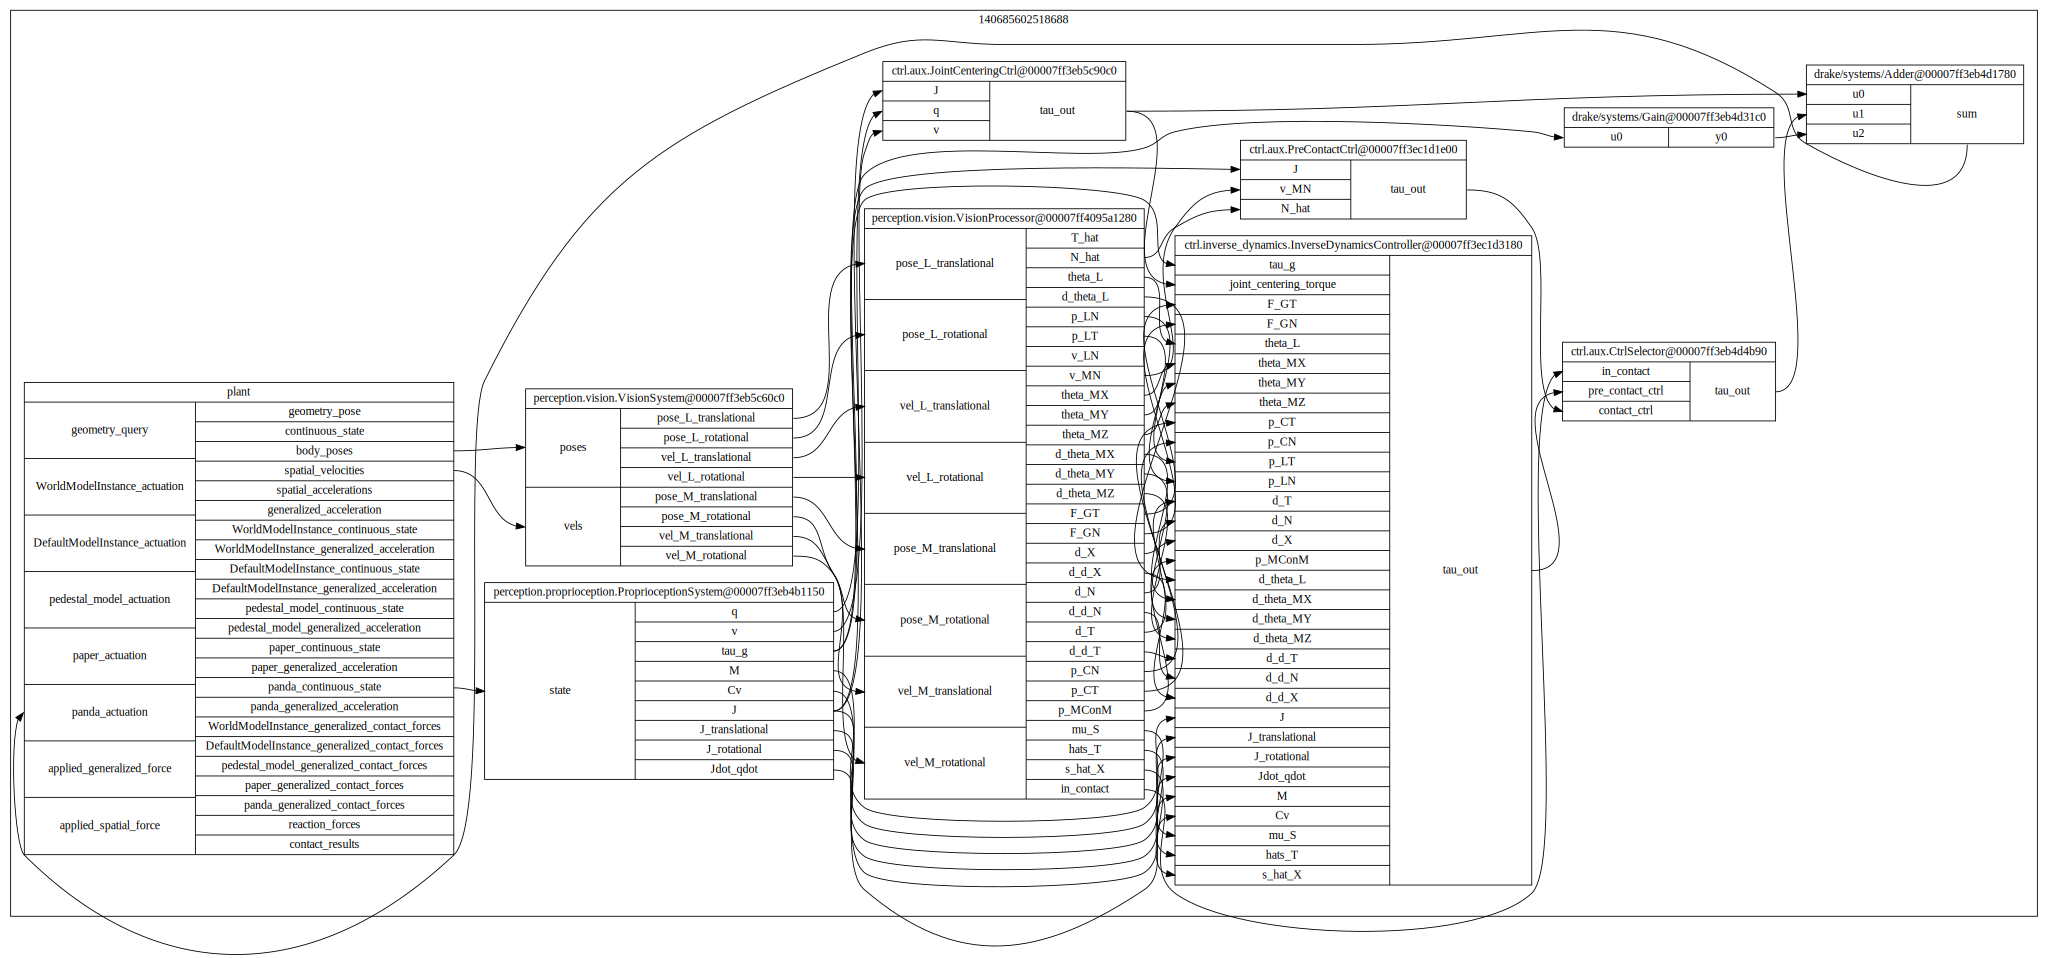

In [24]:
SVG(pydot.graph_from_dot_data(viz_str)[0].create_svg())

# Run simulation

In [25]:
manipulator.data['set_positions'](diagram, diagram_context, plant, manipulator_instance)

In [ ]:
# Finalize simulation and visualization
simulator = pydrake.systems.analysis.Simulator(diagram, diagram_context)
simulator.Initialize()
if not constants.USE_NEW_MESHCAT:
    vis.start_recording()
try:
    simulator.AdvanceTo(constants.TSPAN)
except RuntimeError as e:
    print(e)
except np.linalg.LinAlgError as e:
    print(e)
except AssertionError as e:
    print("Optimization failed")

/Users/dani/Documents/lis/code/PaperManipulation/perception/vision.py:472: RuntimeWarning: invalid value encountered in true_divide
  s_hat = v_S/np.linalg.norm(v_S)
/Users/dani/Documents/lis/code/PaperManipulation/perception/vision.py:478: RuntimeWarning: invalid value encountered in true_divide
  s_hat = v_S/np.linalg.norm(v_S)
[2021-12-16 21:01:30.514] [console] [warning] Currently MultibodyPlant does not handle joint limits for continuous models. However some joints do specify limits. Consider setting a non-zero time step in the MultibodyPlant constructor; this will put the plant in discrete-time mode, which does support joint limits. Joints that specify limits are: 'panda_joint1', 'panda_joint2', 'panda_joint3', 'panda_joint4', 'panda_joint5', 'panda_joint6', 'panda_joint7'


[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]


[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]


[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]


[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]


[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]


In [ ]:
# This way, we can use the actual time the simulation ran for
effective_tspan = max(logger.sample_times())
print("effective_tspan:", effective_tspan)

if not constants.USE_NEW_MESHCAT:
    vis.stop_recording()
    vis.publish_recording()

# Plots used in orginal paper

In [ ]:
# This script is getting huge. We need to turn off parts that we're not using.
generate_paper_plots = False

In [ ]:
if generate_paper_plots:
    # Generate plots for paper
    nb = plant.num_bodies()
    y_traces = []
    z_traces = []
    theta_traces = []
    for b in paper.link_idxs:
        y_traces.append(logger.data()[log_wrapper.entries_per_body*b+1])
        z_traces.append(logger.data()[log_wrapper.entries_per_body*b+2])
        theta_traces.append(logger.data()[log_wrapper.entries_per_body*b+3])
    y_traces = np.array(y_traces)
    z_traces = np.array(z_traces)
    theta_traces = np.array(theta_traces)

    times_ = np.arange(0,effective_tspan, effective_tspan/10)
    cmap = cm.get_cmap("viridis_r")
    plt.figure(figsize=(2*3,2*2))
    for t in times_:
        c = cmap(t/effective_tspan)
        idx = np.argmax(logger.sample_times() >= t)

        # Plot paper
        # PROGRAMMING: Account for paper thickness in plots
        for y, z, theta in zip(y_traces[:,idx], z_traces[:,idx], theta_traces[:,idx]):
            y0 = y - np.cos(theta)*paper.link_width/2
            z0 = z - np.sin(theta)*paper.link_width/2
            y1 = y + np.cos(theta)*paper.link_width/2
            z1 = z + np.sin(theta)*paper.link_width/2
            plt.plot([y0, y1], [z0, z1], color=c)


        # Plot manipulator
        plt.scatter(logger.data()[log_wrapper.entries_per_body*contact_body_idx+1,idx], 
                    logger.data()[log_wrapper.entries_per_body*contact_body_idx+2,idx],
                    color=c, s=300, zorder=1)

    xlim = plt.xlim()
    ylim = plt.ylim()
    plt.scatter([xlim[0]-50, xlim[0]-50], [ylim[0]-50, ylim[0]-50], c=[0, effective_tspan], cmap=cmap)
    plt.xlim(xlim)
    plt.ylim(ylim)
    cb = plt.colorbar()
    cb.set_label("Time")
    plt.xlabel("$y$ position")
    plt.ylabel("$z$ position")
    plt.show()

# Drag plots

This is a sanity check to see how much force we're neglecting by ignoring drag. The colored lines are the drag forces at each link, and the dashed black line is the force due to gravity for scale.

Note that the formula for drag force is $\rho v^2 C_d A_{paper}$.

$C_d$ comes from [this site](https://www.engineersedge.com/fluid_flow/rectangular_flat_plate_drag_14036.htm), which says it depends on $L/d$. For 20 links, $L/d\approx15$. Rounding this down to 10, we get $C_d=1.22$.

In [ ]:
generate_drag_plots = False

In [ ]:
if generate_drag_plots:
    # Plot drag forces
    plt.figure(figsize=(16, 12))
    nb = plant.num_bodies
    vel_traces = []
    for b in paper.link_idxs:
        rho = 1.225
        C_d = paper.link_width*paper.depth
        vel_sqred = logger.data()[log_wrapper.entries_per_body*b+7]**2+logger.data()[log_wrapper.entries_per_body*b+8]**2
        f = 0.5*rho*C_d*vel_sqred
        plt.plot(f)

    plt.axhline(paper.link_mass*9.81, color='black', linestyle='--')
    plt.show()

# Loading signals
Preparing all the signals we'll need.

In [ ]:
debug = fold_ctrl.debug

In [ ]:
min_key_length = np.inf
for k in debug.keys():
    if len(debug[k]) > 0 and len(debug[k]) < min_key_length:
        print(k)
        min_key_length = len(debug[k])
for k in debug.keys():
    debug[k] = debug[k][:min_key_length]

In [ ]:
l_times = logger.sample_times()
d_times = np.array(debug['times'])

## Helper functions

In [ ]:
def diff_vec(vec):
    d_vec = np.diff(vec, axis=0)
    for i in range(vec.shape[1]):
        d_vec[:, i] /= np.expand_dims(np.diff(l_times), 1)
    d_vec = np.concatenate((d_vec, [d_vec[-1]]))
    return d_vec

In [ ]:
def plot_vec(sig1, sig1_label, sig2, sig2_label, finish_plotting=True, plot_x=True, start_time=None):
    if start_time is None:
        idx_start_ = idx_start
    else:
        idx_start_ = np.argmax(l_times > start_time)
    plt.figure(figsize=(16, 8))
    lw = 5
    if plot_x:
        plt.plot(l_times[idx_start_:idx_end], sig1[:,0][idx_start_:idx_end], label=sig1_label + r' $\hat x$ component', color='pink', linewidth=lw)
    plt.plot(l_times[idx_start_:idx_end], sig1[:,1][idx_start_:idx_end], label=sig1_label + r' $\hat y$ component', color='lightgreen', linewidth=lw)
    plt.plot(l_times[idx_start_:idx_end], sig1[:,2][idx_start_:idx_end], label=sig1_label + r' $\hat z$ component', color='lightskyblue', linewidth=lw)
    
    if plot_x:
        plt.plot(l_times[idx_start_:idx_end], sig2[:,0][idx_start_:idx_end], label=sig2_label + r' $\hat x$ component', color='red', linewidth=lw, linestyle='--')
    plt.plot(l_times[idx_start_:idx_end], sig2[:,1][idx_start_:idx_end], label=sig2_label + r' $\hat y$ component', color='green', linewidth=lw, linestyle='--')
    plt.plot(l_times[idx_start_:idx_end], sig2[:,2][idx_start_:idx_end], label=sig2_label + r' $\hat z$ component', color='blue', linewidth=lw, linestyle='--')
    plt.xlabel("Time (seconds)")
    plt.legend()
    plt.autoscale(enable=True, axis='x', tight=True)
    if finish_plotting:
        plt.show()

In [ ]:
def plot_vec_XTN(sig1, sig1_label, sig2, sig2_label, finish_plotting=True, plot_x=True, start_time=None):
    if start_time is None:
        idx_start_ = idx_start
    else:
        idx_start_ = np.argmax(l_times > start_time)
    plt.figure(figsize=(16, 8))
    lw = 5
    
    T_proj1 = np.matmul(T(sig1), T_hat).flatten()
    T_proj2 = np.matmul(T(sig2), T_hat).flatten()
    N_proj1 = np.matmul(T(sig1), N_hat).flatten()
    N_proj2 = np.matmul(T(sig2), N_hat).flatten()
    
    plt.plot(l_times[idx_start_:idx_end], sig1[:,0][idx_start_:idx_end], label=sig1_label + r' $\hat x$ component', color='pink', linewidth=lw)
    plt.plot(l_times[idx_start_:idx_end], T_proj1[idx_start_:idx_end], label=sig1_label + r' $\hat T$ component', color='lightgreen', linewidth=lw)
    plt.plot(l_times[idx_start_:idx_end], N_proj1[idx_start_:idx_end], label=sig1_label + r' $\hat N$ component', color='lightskyblue', linewidth=lw)
    
    plt.plot(l_times[idx_start_:idx_end], sig2[:,0][idx_start_:idx_end], label=sig2_label + r' $\hat x$ component', color='red', linewidth=lw, linestyle='--')
    plt.plot(l_times[idx_start_:idx_end], T_proj2[idx_start_:idx_end], label=sig2_label + r' $\hat T$ component', color='green', linewidth=lw, linestyle='--')
    plt.plot(l_times[idx_start_:idx_end], N_proj2[idx_start_:idx_end], label=sig2_label + r' $\hat N$ component', color='blue', linewidth=lw, linestyle='--')
    plt.xlabel("Time (seconds)")
    plt.legend()
    plt.autoscale(enable=True, axis='x', tight=True)
    if finish_plotting:
        plt.show()

In [ ]:
def diff_arr(arr):
    d_arr = np.diff(arr)/np.diff(l_times)
    d_arr = np.concatenate((d_arr, [d_arr[-1]]))
    return d_arr

In [ ]:
# Friction helper functions
def step5(x):
    '''Python version of MultibodyPlant::StribeckModel::step5 method'''
    x3 = x * x * x
    return x3 * (10 + x * (6 * x - 15))

def stribeck(us, uk, v):
    '''
    Python version of MultibodyPlant::StribeckModel::ComputeFrictionCoefficient
    
    From
    https://github.com/RobotLocomotion/drake/blob/b09e40db4b1c01232b22f7705fb98aa99ef91f87/multibody/plant/images/stiction.py
    '''
    u = np.zeros_like(v) + uk
    u[v < 1] = us * step5(v[v < 1])
    mask = (v >= 1) & (v < 3)
    u[mask] = us - (us - uk) * step5((v[mask] - 1) / 2)
    return u

In [ ]:
def T(vec):
    return np.transpose(vec, [0, 2, 1])

## Inputs
These should all come from simulation/geometry, since they are inputs to the controller and are "fixed" from the controller's perspective.

In [ ]:
nq = manipulator.data['nq']

### Geometric quantities ($m_L, m_M, w_L, I_L, h_L, \mu$)

In [ ]:
m_L = paper.link_mass
w_L = paper.link_width
I_L = paper.plant.get_body(
    BodyIndex(paper.link_idxs[-1])).default_rotational_inertia().CalcPrincipalMomentsOfInertia()[0]
h_L = paper.height
mu_paper = constants.FRICTION
mu = 2*mu_paper/(1+mu_paper) # 2μₘμₙ/(μₘ + μₙ)
b_J = paper.damping
k_J = paper.stiffness

### Gravity, unit vectors ($F_{GT}, F_{GN}, \hat T, \hat N$)

In [ ]:
# Assume plane contact, so all N_hat should point the same direction
# TODO: verify all point in the same direction
N_hat_raw = logger.data()[log_wrapper.contact_entry_start_idx+14:log_wrapper.contact_entry_start_idx+17,:].copy() # So it's writeable
N_hat = np.expand_dims(N_hat_raw.T, 2)
N_hat[:,0][np.isnan(N_hat[:,0])] = 0
N_hat[:,1][np.isnan(N_hat[:,1])] = 0
N_hat[:,2][np.isnan(N_hat[:,2])] = 1

In [ ]:
T_hat = np.matmul(
    np.array([
        [1,  0, 0],
        [0,  0, 1],
        [0, -1, 0],
    ]),
    N_hat)

It's also useful here to calculate project matrices:

In [ ]:
N_hat_proj_mat = np.matmul(N_hat, np.transpose(N_hat, [0, 2, 1]))

In [ ]:
g = plant.gravity_field().gravity_vector()[-1]*-1
F_G = np.zeros([l_times.size, 3, 1])
F_G[:,2,0] = -np.ones_like(l_times)*g*m_L
F_GT = np.matmul(T(F_G), T_hat).flatten()
F_GN = np.matmul(T(F_G), N_hat).flatten()

In [ ]:
idx = log_wrapper.tau_g_start_idx
length = manipulator.data["nq"]
tau_g = np.expand_dims(logger.data()[idx:idx+length].T, 2)

### Positions, velocities ($\dot\theta^2, r_T, \dot d_T$)

#### Object poses & vels

In [ ]:
idx = log_wrapper.get_idx("pos", "trn", ll_idx)
length = 3
p_L = np.expand_dims(logger.data()[idx:idx+length].T, 2)
p_LN = np.matmul(T(p_L), N_hat).flatten()
p_LT = np.matmul(T(p_L), T_hat).flatten()
p_LX = p_L[:,0].flatten()

In [ ]:
theta_L = logger.data()[log_wrapper.get_idx("pos", "rot", ll_idx)]

In [ ]:
theta_MX = logger.data()[log_wrapper.get_idx("pos", "rot", contact_body_idx)]
theta_MY = logger.data()[log_wrapper.get_idx("pos", "rot", contact_body_idx)+1]
theta_MZ = logger.data()[log_wrapper.get_idx("pos", "rot", contact_body_idx)+2]

In [ ]:
d_theta_L = logger.data()[log_wrapper.get_idx("vel", "rot", ll_idx)]
d_theta_M = logger.data()[log_wrapper.get_idx("vel", "rot", contact_body_idx)]

In [ ]:
x_hat = np.zeros((len(l_times), 3, 1))
x_hat[:,0,:] = 1

y_hat = np.zeros((len(l_times), 3, 1))
y_hat[:,1,:] = 1

z_hat = np.zeros((len(l_times), 3, 1))
z_hat[:,2,:] = 1

In [ ]:
idx = log_wrapper.get_idx("vel", "trn", ll_idx)
length = 3
v_L = np.expand_dims(logger.data()[idx:idx+length].T,2)
v_LN = np.matmul(T(v_L), N_hat).flatten()
v_LT = np.matmul(T(v_L), T_hat).flatten()
v_LX = v_L[:,0].flatten()

In [ ]:
idx = log_wrapper.get_idx("pos", "trn", contact_body_idx)
length = 3
p_M = np.expand_dims(logger.data()[idx:idx+length].T, 2)
p_MN = np.matmul(T(p_M), N_hat).flatten()
p_MT = np.matmul(T(p_M), T_hat).flatten()
p_MX = p_M[:,0].flatten()

In [ ]:
idx = log_wrapper.get_idx("pos", "rot", contact_body_idx)
length = 3
np.expand_dims(logger.data()[idx:idx+length].T, 2)[0]

In [ ]:
idx = log_wrapper.get_idx("vel", "trn", contact_body_idx)
length = 3
v_M = np.expand_dims(logger.data()[idx:idx+length].T, 2)
v_MN = np.matmul(T(v_M), N_hat).flatten()
v_MT = np.matmul(T(v_M), T_hat).flatten()
v_MX = v_M[:,0].flatten()

#### Manipulator eq. terms

In [ ]:
idx = log_wrapper.J_start_idx
length = manipulator.data["nq"]*6
J = np.transpose(logger.data()[idx:idx+length].reshape(6, nq, len(l_times)), [2, 0, 1])
J_rotational = J[:,:3,:]
J_translational = J[:,3:,:]

In [ ]:
joint_centering_torque = scipy.interpolate.interp1d(
    d_times, 
    np.array(fold_ctrl.debug['joint_centering_torque']),
    axis=0)(l_times)

In [ ]:
q = np.expand_dims((logger.data()[log_wrapper.state_start_idx:log_wrapper.state_start_idx + nq,:]).T, 2)
d_q = np.expand_dims((logger.data()[log_wrapper.state_start_idx + nq:log_wrapper.state_start_idx + nq*2,:]).T, 2)

In [ ]:
idx = log_wrapper.M_start_idx
length = manipulator.data["nq"]*manipulator.data["nq"]
M = np.transpose(logger.data()[idx:idx+length].reshape(nq, nq, len(l_times)), [2, 0, 1])

In [ ]:
idx = log_wrapper.Cv_start_idx
length = manipulator.data["nq"]
Cv = np.expand_dims(logger.data()[idx:idx+length].T, 2)

In [ ]:
idx = log_wrapper.Jdot_qdot_start_idx
length = 6
Jdot_qdot = np.expand_dims(logger.data()[idx:idx+length].T, 2)

#### Body derived terms
Meaning terms derived from the positions/velocities of bodies

In [ ]:
R = np.zeros((len(l_times), 3, 3))
R[:,1,1] = np.cos(theta_L)
R[:,1,2] = -np.sin(theta_L)
R[:,2,1] = np.sin(theta_L)
R[:,2,2] = np.cos(theta_L)

In [ ]:
T_hat_geo = np.matmul(R, y_hat)
N_hat_geo = np.matmul(R, z_hat)

In [ ]:
# Link edge
p_LE = p_L + (w_L/2)*T_hat-(h_L/2)*N_hat

In [ ]:
omega_vec_L = np.expand_dims(np.vstack((d_theta_L, np.zeros_like(d_theta_L), np.zeros_like(d_theta_L))).T, 2)
idx = log_wrapper.get_idx("vel", "rot", contact_body_idx)
length = 3
omega_vec_M = np.expand_dims(logger.data()[idx:idx+length].T, 2)

In [ ]:
J_dot = diff_vec(J)

#### Contact terms
TODO: edit out/simplify eventually

In [ ]:
contact_point = logger.data()[log_wrapper.contact_entry_start_idx+11:log_wrapper.contact_entry_start_idx+14,:]

In [ ]:
p_C = np.expand_dims(contact_point.T, 2)
p_CT = np.matmul(T(p_C), T_hat).flatten()
p_CN = np.matmul(T(p_C), N_hat).flatten()

In [ ]:
r = np.linalg.norm(p_C - p_M, axis=1).flatten()

In [ ]:
# Assume all the slip speeds are the same
# TODO: verify
slip_speed = logger.data()[log_wrapper.contact_entry_start_idx+10,:]

In [ ]:
# d vector
d_vec = p_C - p_LE
d_T = np.matmul(T(d_vec), T_hat).flatten()
d_N = np.matmul(T(d_vec), N_hat).flatten()
d_X = d_vec[:,0].flatten()

In [ ]:
d_d_T = -d_theta_L*h_L/2-d_theta_L*r - v_LT + v_MT + d_theta_L*d_N
d_d_N = -d_theta_L*w_L/2-v_LN+v_MN-d_theta_L*d_T
d_d_X = diff_arr(d_X)

In [ ]:
dd_d_T = diff_arr(d_d_T)
dd_d_N = diff_arr(d_d_N)
dd_d_X = diff_arr(d_d_X)

In [ ]:
d_d_vec = diff_vec(d_vec)
d_d_vec_T = np.matmul(T(d_d_vec), T_hat).flatten()
d_d_vec_N = np.matmul(T(d_d_vec), N_hat).flatten()

In [ ]:
p_MConM = p_C - p_M
p_LConL = p_C - p_L

v_WConM = v_M + np.cross(omega_vec_M, p_MConM, axis=1)
v_WConL = v_L + np.cross(omega_vec_L, p_LConL, axis=1)

v_S_raw = v_WConM - v_WConL
v_S_N = np.matmul(N_hat_proj_mat, v_S_raw)
v_S = v_S_raw - v_S_N
v_S = v_S_raw - v_S_N
s_S = np.linalg.norm(v_S, axis=1).flatten()

In [ ]:
s_hat = v_S/np.expand_dims(np.linalg.norm(v_S, axis=1), 2)
s_hat_X = s_hat[:,0].flatten()
s_hat_T = np.matmul(T(s_hat), T_hat).flatten()

In [ ]:
d_d_T_diff = diff_arr(d_T)
d_d_N_diff = diff_arr(d_N)

### Friction coeficients

In [ ]:
mu_S = stribeck(1, 1, slip_speed/v_stiction)

## Outputs
These should all come directly from simulation, except for control forces.
### Measured accelerations ($a_{LT}, a_{LN}, a_{MT}, a_{MN}, \ddot\theta$)

In [ ]:
idx = log_wrapper.get_idx("acc", "trn", ll_idx)
length = 3
a_L = np.expand_dims(logger.data()[idx:idx+length].T, 2)
a_LX = np.matmul(T(a_L), x_hat).flatten()
a_LT = np.matmul(T(a_L), T_hat).flatten()
a_LN = np.matmul(T(a_L), N_hat).flatten()

In [ ]:
idx = log_wrapper.get_idx("acc", "trn", contact_body_idx)
length = 3
a_M = np.expand_dims(logger.data()[idx:idx+length].T, 2)
a_MT = np.matmul(T(a_M), T_hat).flatten()
a_MN = np.matmul(T(a_M), N_hat).flatten()
a_MX = a_M[:,0].flatten()
a_MY = a_M[:,1].flatten()
a_MZ = a_M[:,2].flatten()

In [ ]:
idx = log_wrapper.get_idx("acc", "rot", contact_body_idx)
length = 3
alpha_M = np.expand_dims(logger.data()[idx:idx+length].T, 2)
alpha_MT = np.matmul(T(alpha_M), T_hat).flatten()
alpha_MN = np.matmul(T(alpha_M), N_hat).flatten()
alpha_MX = alpha_M[:,0].flatten()
alpha_MY = alpha_M[:,1].flatten()
alpha_MZ = alpha_M[:,2].flatten()

In [ ]:
dd_theta_L = logger.data()[log_wrapper.get_idx("acc", "rot", ll_idx)]
dd_theta_M = logger.data()[log_wrapper.get_idx("acc", "rot", contact_body_idx)]

In [ ]:
dd_q = np.expand_dims((logger.data()[log_wrapper.gen_accs_start_idx:
                                     log_wrapper.gen_accs_start_idx+nq,:]).T, 2)

### Contact forces ($F_{NL}, F_{FL}, F_{NM}, F_{FM}$)
Slightly different then just taking normal/tangent projections.

In [ ]:
F_NM = np.zeros(len(l_times))
F_FMT = np.zeros(len(l_times))
F_FMX = np.zeros(len(l_times))
F_ContactM_XYZ = np.zeros((len(l_times), 3, 1))
tau_contact = np.zeros((len(l_times), nq, 1))
for i in range(log_wrapper.max_contacts):
    # Pull out terms
    start_idx = log_wrapper.contact_entry_start_idx + log_wrapper.entries_per_contact*i
    contact_point = np.expand_dims(logger.data()[start_idx+11:start_idx+14,:].T, 2)
    if np.all(np.isnan(contact_point)):
        break

    # Calculate intermediautes
    lever_arm = contact_point - p_M
    force = np.expand_dims(logger.data()[start_idx+0:start_idx+3,:].T, 2)
    torque = np.cross(lever_arm, force, axis=1)
    wrench = np.hstack((torque, force))
    
    # Calculate updates
    F_FMT_update = np.matmul(T(force), T_hat).flatten()
    F_NM_update = np.matmul(T(force), N_hat).flatten()
    F_FMX_update = force[:,0].flatten()
    F_ContactM_XYZ_update = force
    
    # Update
    tau_contact += np.matmul(T(J), wrench)
    F_FMT += F_FMT_update
    F_NM += F_NM_update
    F_FMX += F_FMX_update
    F_ContactM_XYZ += F_ContactM_XYZ_update
    
F_NM = np.nan_to_num(F_NM)
F_FMT = np.nan_to_num(F_FMT)
F_FMX = np.nan_to_num(F_FMX)
tau_contact = np.nan_to_num(tau_contact)
F_ContactM_XYZ = np.nan_to_num(F_ContactM_XYZ)

In [ ]:
F_FLT = -F_FMT
F_FLX = -F_FMX
F_NL = -F_NM

In [ ]:
# Equivalent contact forces for each object
F_contact_M = np.expand_dims(F_FMX, [1, 2])*x_hat + \
                  np.expand_dims(F_FMT, [1, 2])*T_hat + \
                  np.expand_dims(F_NM, [1, 2])*N_hat

In [ ]:
F_contact_L = np.expand_dims(F_FLX, [1, 2])*x_hat + \
              np.expand_dims(F_FLT, [1, 2])*T_hat + \
              np.expand_dims(F_NL, [1, 2])*N_hat

### Object forces ($F_{ON}, F_{OT}, \tau_O$)

In [ ]:
idx = log_wrapper.get_last_jnt_idx("trn")
joint_force_in_compliance_frame = logger.data()[idx:idx+3]

In [ ]:
# Copy makes it mutable
F_OX = joint_force_in_compliance_frame[0,:].copy()
F_OT = joint_force_in_compliance_frame[1,:].copy()
F_ON = joint_force_in_compliance_frame[2,:].copy()

In [ ]:
F_OX_orig = F_OX.copy()

In [ ]:
joint_force_in_compliance_frame[0]

In [ ]:
idx = log_wrapper.get_last_jnt_idx("rot")
joint_torque_in_compliance_frame = logger.data()[idx:idx+3]

In [ ]:
# Copy makes it mutable
tau_O = joint_torque_in_compliance_frame[0,:].copy()

In [ ]:
F_OX = np.nan_to_num(F_OX)
F_OT = np.nan_to_num(
F_OT)
F_ON = np.nan_to_num(
F_ON)
tau_O = np.nan_to_num(
tau_O)

## Control terms

In [ ]:
tau_ctrl_no_interp = np.array(fold_ctrl.debug['tau_ctrl'])
tau_ctrl = scipy.interpolate.interp1d(fold_ctrl.debug['times'], tau_ctrl_no_interp, axis=0)(l_times)

In [ ]:
tau_out_no_interp = np.array(fold_ctrl.debug['tau_out'])
tau_out = scipy.interpolate.interp1d(fold_ctrl.debug['times'], tau_out_no_interp, axis=0)(l_times)

### Other outputs

In [ ]:
forces_found = logger.data()[-1,:]

In [ ]:
in_contact = logger.data()[log_wrapper.calc_in_contact_start_idx]

In [ ]:
t = l_times

# Plotting settings

In [ ]:
lw = 5

## Setting up time

In [ ]:
plt.figure(figsize=(16,4))
# plt.plot(l_times, raw_in_contact, color='skyblue', linewidth=2, label="Raw")
plt.plot(l_times, in_contact, "b--", linewidth=2, label="Filtered")
plt.legend()
plt.autoscale(enable=True, axis='x', tight=True)

In [ ]:
contact_data = in_contact

In [ ]:
first_contact_idx = np.argmax(contact_data)
last_contact_idx = contact_data.size - np.argmax(contact_data[::-1]-1)-1
l_times[last_contact_idx]

In [ ]:
last_not_in_contact_idx = contact_data.size - np.argmax(np.logical_not(contact_data[::-1])-1)-1
t_start_of_last_contact = t[min(last_not_in_contact_idx+1, len(l_times) - 1)]

In [ ]:
t_start = t[first_contact_idx]
t_end = t[last_contact_idx]-0.05
idx_start = np.argmax(l_times > t_start)
idx_end = np.argmax(l_times > t_end)
if idx_end == 0:
    idx_end = len(l_times) - 1

In [ ]:
t_start

In [ ]:
t_end

## Defining functions

In [ ]:
def plot_eq(lhs, lhs_label, rhs, rhs_label, lhs_alpha=1, rhs_alpha=1, lw=5, finish_plotting=True, 
            plot_diff=True, figsize_=None, plot_err_as_pct=False, t_start=t_start, newline_in_title=False, t_end=t_end):
    if figsize_ is not None:
        plt.figure(figsize=figsize_)
    else:
        plt.figure(figsize=default_figsize)
    if isinstance(lhs, float) or isinstance(lhs, int):
        lhs = np.ones_like(l_times)*lhs
    if isinstance(rhs, float) or isinstance(rhs, int):
        rhs = np.ones_like(l_times)*rhs
    idx_start = np.argmax(l_times > t_start)
    idx_end = np.argmax(l_times > t_end)
    if idx_end == 0:
        idx_end = len(l_times) - 1
        
    b = np.broadcast(lhs, rhs)
    if np.count_nonzero(np.array(b.shape) > 1000) > 1:
        raise ValueError("Broadcast shape of lhs and rhs is {}, which is too large.".format(b.shape))
        
    plt.subplot(211)
    error = lhs[idx_start:idx_end]-rhs[idx_start:idx_end]
    if plot_err_as_pct:
        lhs_range = np.nanmax(lhs[idx_start:idx_end]) - np.nanmin(lhs[idx_start:idx_end])
        rhs_range = np.nanmax(rhs[idx_start:idx_end]) - np.nanmin(rhs[idx_start:idx_end])
        
        lhs_max_val = np.nanmax(np.abs(lhs[idx_start:idx_end]))
        rhs_max_val = np.nanmax(np.abs(rhs[idx_start:idx_end]))
        error /= np.nanmax([lhs_max_val, rhs_max_val])
        error *= 100
        
    plt.plot(l_times[idx_start:idx_end],
            error,
            linewidth=lw)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.xlabel("Time (s)")
    if plot_err_as_pct:
        plt.ylabel("Error (percent of max val)")
    else:
        plt.ylabel("Error")
    if newline_in_title:
        plt.title("Difference between {}\n and {}".format(lhs_label, rhs_label))
    else:
        plt.title("Difference between {} and {}".format(lhs_label, rhs_label))
    
    
    plt.subplot(212)
    plt.plot(l_times[idx_start:idx_end],
             lhs[idx_start:idx_end],
             label=lhs_label, linewidth=lw, color='lightskyblue', zorder=0, alpha=lhs_alpha)
    plt.plot(l_times[idx_start:idx_end],
             rhs[idx_start:idx_end],
             label=rhs_label, linewidth=lw, color='b', linestyle='--', zorder=1, alpha=rhs_alpha)
    plt.autoscale(enable=True, axis='x', tight=True)
    
#     plt.axvline(t[np.argmax(in_contact)] + 0.5, color='k', linewidth=lw, linestyle='--')
    
    
#     plt.axvline(t[first_contact_idx], color='green', linewidth=lw)
#     plt.axvline(t_lose_contact, color='red', linewidth=lw)
    
    plt.legend()
    plt.xlabel("Time (s)")
    
    if finish_plotting:
        plt.show()

In [ ]:
errors = []
max_errors = []
med_errors = []
max_error_pct = []
med_error_pct = []
error_labels = []

In [ ]:
def update_error(lhs, lhs_label, rhs, rhs_label, newline_in_label=False):
    error = ((lhs) - (rhs))[idx_start:idx_end]
    
    if isinstance(lhs, float) or isinstance(lhs, int):
        lhs = np.ones_like(l_times)*lhs
    if isinstance(rhs, float) or isinstance(rhs, int):
        rhs = np.ones_like(l_times)*rhs
    max_val_l = np.max(np.abs(lhs[idx_start:idx_end]))
    max_val_r = np.max(np.abs(rhs[idx_start:idx_end]))
    max_val = max(max_val_l,max_val_r)
    
    label = r"$\left(" + lhs_label.replace("$", "") + r"\right) "
    if newline_in_label:
        label += "$\n$"
    label += "- \left(" + rhs_label.replace("$", "") + r"\right)$"
    label_idx = None
    for i, l in enumerate(error_labels):
        if l == label:
            label_idx = i
            break
    max_error = np.nanmax(np.abs(error))
    med_error = np.median(np.abs(error[np.logical_not(np.isnan(error))]))
    if label_idx is None:
        errors.append(error)
        error_labels.append(label)
        max_errors.append(max_error)
        med_errors.append(med_error)
        max_error_pct.append(max_error/max_val)
        med_error_pct.append(max_error/max_val)
    else:
        errors[label_idx] = error
        max_errors[label_idx] = max_error
        med_errors[label_idx] = med_error
        max_error_pct[label_idx] = max_error/max_val
        med_error_pct[label_idx] = med_error/max_val

# Plots (environmental constraints)
There are things where I expect them to be satisfied no matter what, no matter the succes my controller.

## Link (x) accel $m_La_{LX} = F_{FLX} + F_{OX}$

In [ ]:
lhs_label = r'$m_La_{LX}$'
rhs_label = r'$F_{FLX} + F_{OX}$'

lhs = m_L*a_LX

rhs = F_FLX + F_OX

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

## Link (T) accel $m_La_{LT} = F_{FLT} + F_{GT} +F_{OT}$
*If this plot is correct:*
The free body diagram is correct in thet $\hat T$ direction on the link.

In [ ]:
lhs_label = r'$m_La_{LT}$'
rhs_label = r'$F_{FLT} + F_{GT} +F_{OT}$'

lhs = m_L*a_LT
# lhs /= np.max(np.abs(lhs[idx_start:idx_end]))

rhs = F_GT+F_OT+F_FLT
# rhs /= np.max(np.abs(rhs[idx_start:idx_end]))

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

## Link (N) accel $m_La_{LN} = F_{NL} + F_{GN} +F_{ON}$
*If this plot is correct:*
The free body diagram is correct in thet $\hat N$ direction on the link.

In [ ]:
lhs_label = r'$m_La_{LN}$'
rhs_label = r'$F_{NL} + F_{GN} +F_{ON}$'

lhs = m_L*a_LN

rhs = F_NL + F_GN + F_ON

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

## Link (x) angle accel $I_L\ddot\theta_L = -\frac{w_L}{2}F_{ON} - (p_{CN}-p_{LN})F_{FL} + (p_{CT}-p_{LT})F_{NL}+\tau_O$
*If this plot is correct:* The moment balance on the link is correct.

In [ ]:
lhs_label = r'$I_L\ddot\theta$'
rhs_label = r'$-\frac{w_L}{2}F_{ON} - (p_{CN}-p_{LN})F_{FL} + (p_{CT}-p_{LT})F_{NL}+\tau_O$'

lhs = I_L*dd_theta_L

N_lever_arm = np.nan_to_num(p_CN-p_LN)
T_lever_arm = np.nan_to_num(p_CT-p_LT)
rhs = (-w_L/2)*F_ON - N_lever_arm * F_FLT + T_lever_arm*F_NL + tau_O

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

## 3rd law normal forces $F_{NL} = -F_{NM}$
*If this plot is correct:* Newton's 3rd law is correction applied to the normal forces.

In [ ]:
lhs_label = r'$F_{NL}$'
rhs_label = r'$-F_{NM_{top}}-F_{NM_{bot}}$'

lhs = F_NL

rhs = -F_NM

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

## 3rd law friction forces $F_{FLT} = -F_{FMT}$
*If this plot is correct:* Newton's 3rd law is correction applied to the friction forces in the tangent direction.

In [ ]:
lhs_label = r'$F_{FLT}$'
rhs_label = r'$-F_{FMT}$'

lhs = F_FLT

rhs = -F_FMT

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

## d vec tangential derivative $-\ddot\theta_L h_L/2 - \ddot\theta_L r + \dot\theta_L^2 w_L/2 - a_{LT} + a_{MT} = -\ddot\theta_L {d}_N + \ddot{d}_T - \dot\theta_L^2 {d}_T - 2\dot\theta_L \dot{d}_N$
*If this plot is correct:* The derivatives for  $\vec d$  are correct.

In [ ]:
lhs = -dd_theta_L*(h_L/2+r) + d_theta_L**2*w_L/2 - a_LT + a_MT
lhs_label = r"$-\ddot\theta_L h_L/2 - \ddot\theta_L r + \dot\theta_L^2 w_L/2 - a_{LT} + a_{MT}$"

rhs = -dd_theta_L*d_N + dd_d_T - d_theta_L**2*d_T - 2*d_theta_L*d_d_N
rhs_label = r"$-\ddot\theta_L {d}_N + \ddot{d}_T - \dot\theta_L^2 {d}_T - 2\dot\theta_L \dot{d}_N$"

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label, newline_in_label=True)

## d vec normal derivative $- \frac{w_{L}}{2}\ddot\theta_{L} - \frac{h_{L}}{2}\dot\theta_{L}^{2} - \dot\theta_{L}^{2} r - a_{LN} + a_{MN} = \ddot\theta_{L} d_{T} + \ddot{d}_N - \dot\theta_{L}^{2} d_{N} + 2 \dot\theta_{L} \dot{d}_T$
*If this plot is correct:* The derivatives for  $\vec d$  are correct.

In [ ]:
lhs = -dd_theta_L*w_L/2 - d_theta_L**2*h_L/2 - d_theta_L**2*r - a_LN + a_MN
lhs_label = r"$-\ddot\theta_L w_L/2 - \dot\theta_L^2 h_L/2 - \dot\theta_L^2 r - a_{LN} + a_{MN}$ (differentiating geometry)"

rhs = dd_theta_L*d_T + dd_d_N - d_theta_L**2*d_N + 2*d_theta_L*d_d_T
rhs_label = r"$\ddot\theta_L {d}_T + \ddot{d}_N - \dot\theta_L^2 {d}_N + 2 \dot\theta_L \dot{d}_T$ (differentiating vector)"

plot_eq(lhs, lhs_label, rhs, rhs_label, newline_in_title=True)

lhs_label = r"$-\ddot\theta_L w_L/2 - \dot\theta_L^2 h_L/2 - \dot\theta_L^2 r - a_{LN} + a_{MN}$"
rhs_label = r"$\ddot\theta_L {d}_T + \ddot{d}_N - \dot\theta_L^2 {d}_N + 2 \dot\theta_L \dot{d}_T$"
update_error(lhs, lhs_label, rhs, rhs_label, newline_in_label=True)
plt.show()

## No penetration $\ddot d_N = 0$
*If this plot is correct:* There is effectively no penetration between the rigid bodies.

In [ ]:
lhs_label = r'$\ddot{d}_N$'
rhs_label = r'0'

lhs = dd_d_N

rhs = 0

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

## Link (T) friction equation $F_{FLT}=\mu\mu_SF_{NL}\hat s_T$

In [ ]:
lhs_label = r'$\mu\mu_SF_{NL}\hat s_T$'
rhs_label = r'$F_{FLT}$'

lhs = np.nan_to_num(mu_S*F_NL*mu*s_hat_T)
rhs = F_FLT

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

## Link (x) friction equation $F_{FLX}=\mu\mu_SF_{NL}\hat s_X$

In [ ]:
lhs_label = r'$\mu\mu_SF_{NL}\hat s_X$'
rhs_label = r'$F_{FLX}$'

lhs = np.nan_to_num(mu_S*F_NM*mu*s_hat_X)
rhs = F_FMX

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

## Jacobian and (x) accel $a_{MX}=\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_3$

In [ ]:
lhs_label = r'$a_{MX}$'
rhs_label = r'$\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_3$'

lhs = a_MX
rhs = (Jdot_qdot + np.matmul(J, dd_q))[:,3].flatten()

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

## Jacobian and (y) accel $a_{MY}=\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_4$

In [ ]:
lhs_label = r'$a_{MY}$'
rhs_label = r'$\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_4$'

lhs = a_MY
rhs = (Jdot_qdot + np.matmul(J, dd_q))[:,4].flatten()

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

## Jacobian and (z) accel $a_{MZ}=\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_5$

In [ ]:
lhs_label = r'$a_{MZ}$'
rhs_label = r'$\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_5$'

lhs = a_MZ
rhs = (Jdot_qdot + np.matmul(J, dd_q))[:,5].flatten()

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

## Jacobian and (x) ang accel $\alpha_{MX}=\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_0$

In [ ]:
lhs_label = r'$\alpha_{MX}$'
rhs_label = r'$\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_0$'

lhs = alpha_MX
rhs = (Jdot_qdot + np.matmul(J, dd_q))[:,0].flatten()

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

## Jacobian and (y) ang accel $\alpha_{MY}=\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_1$

In [ ]:
lhs_label = r'$\alpha_{MY}$'
rhs_label = r'$\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_1$'

lhs = alpha_MY
rhs = (Jdot_qdot + np.matmul(J, dd_q))[:,1].flatten()

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

## Jacobian and (z) ang accel $\alpha_{MZ}=\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_2$

In [ ]:
lhs_label = r'$\alpha_{MZ}$'
rhs_label = r'$\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_2$'

lhs = alpha_MZ
rhs = (Jdot_qdot + np.matmul(J, dd_q))[:,2].flatten()

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

## Manipulator equation $M \ddot q + C \dot q = \tau_g + \vec \tau_{\text{contact}} + \vec \tau_{\text{out}}$

In [ ]:
lhs_ = np.matmul(M, dd_q) + Cv
lhs_label_ = r"M \ddot q + C \dot q"
rhs_ = tau_g + tau_contact + tau_out
rhs_label_ = r"\tau_g + \vec \tau_{contact} + \vec \tau_{out}"
labels = [str(i) for i in range(nq)]

for i, label in enumerate(labels):
    lhs = lhs_[:,i,:]
    lhs_label = r"$\left(" + lhs_label_ + r"\right)_" + label + "$"

    rhs = rhs_[:,i,:]
    rhs_label = r"$\left(" + rhs_label_ + r"\right)_" + label + "$"

    plot_eq(lhs, lhs_label, rhs, rhs_label)
    update_error(lhs, lhs_label, rhs, rhs_label)
    plt.show()

## Tau out vs tau ctrl $\vec \tau_{\text{out}} = \vec\tau_{\text{ctrl}} - \tau_g + \tau_{\text{joint centering}}$

In [ ]:
lhs_ = tau_out
lhs_label_ = r"\tau_{out}"
rhs_ = tau_ctrl - tau_g + joint_centering_torque
rhs_label_ = r"\vec\tau_{ctrl} - \tau_g + \tau_{joint centering}"
labels = [str(i) for i in range(nq)]

for i, label in enumerate(labels):
    lhs = lhs_[:,i,:]
    lhs_label = r"$\left(" + lhs_label_ + r"\right)_" + label + "$"

    rhs = rhs_[:,i,:]
    rhs_label = r"$\left(" + rhs_label_ + r"\right)_" + label + "$"

    plot_eq(lhs, lhs_label, rhs, rhs_label)
    update_error(lhs, lhs_label, rhs, rhs_label)
    plt.show()

# Plot errors
How accurate is my modeling?

## Absolute error

In [ ]:
plt.figure(figsize=(16,16))
plt.barh(error_labels[::-1], np.array(max_errors[::-1]), label="Maximum error")
plt.barh(error_labels[::-1], np.array(med_errors[::-1]), label="Median error")
plt.axvline(1e-5, color='k', linestyle='--', label="1e-5")
plt.xscale("log")
plt.xlabel("Log(error)")
plt.xlabel("Error")
plt.ylabel("Equation")
plt.legend()
# plt.xlim(0, 100)
plt.show()

## Percent error

In [ ]:
plt.figure(figsize=(16,16))
plt.barh(error_labels[::-1], np.array(max_error_pct[::-1])*100, label="Maximum error")
plt.barh(error_labels[::-1], np.array(med_error_pct[::-1])*100, label="Median error")
plt.axvline(5, color='k', linestyle='--', label="5% error")
# plt.xscale("log")
# plt.xlabel("Log(error)")
plt.xlabel("Percent error")
plt.ylabel("Equation")
plt.legend()
plt.xlim(0, 100)
plt.show()

# Environmental constraints (two link specific)

In [ ]:
lhs = a_LT
lhs_label = r"$a_{LT}$"
rhs = (-w_L/2)*d_theta_L**2
rhs_label = r"$-\frac{w_L}{2}\dot\theta^2$"
plot_eq(lhs, lhs_label, rhs, rhs_label)

In [ ]:
lhs = a_LN
lhs_label = r"$a_{LN}$"
rhs = (w_L/2)*dd_theta_L
rhs_label = r"$\frac{w_L}{2}\ddot\theta$"
plot_eq(lhs, lhs_label, rhs, rhs_label)

# Control performance (for inverse dynamics)

## Conformity to artificial constraints

In [ ]:
ctrlr_is_inverse_dynamics = type(fold_ctrl) is controller.FoldingInverseDynamicsController

In [ ]:
if ctrlr_is_inverse_dynamics:
    dd_d_Td = scipy.interpolate.interp1d(d_times, debug['dd_d_Td'], axis=0)(l_times)
    dd_theta_Ld = scipy.interpolate.interp1d(d_times, debug['dd_theta_Ld'], axis=0)(l_times)
    a_MXd = scipy.interpolate.interp1d(d_times, debug['a_MX_d'], axis=0)(l_times)
    alpha_MXd = scipy.interpolate.interp1d(d_times, debug['alpha_MXd'], axis=0)(l_times)
    alpha_MYd = scipy.interpolate.interp1d(d_times, debug['alpha_MYd'], axis=0)(l_times)
    alpha_MZd = scipy.interpolate.interp1d(d_times, debug['alpha_MZd'], axis=0)(l_times)
    dd_d_Nd = scipy.interpolate.interp1d(d_times, debug['dd_d_Nd'], axis=0)(l_times)

In [ ]:
if ctrlr_is_inverse_dynamics:
    theta_MXd = scipy.interpolate.interp1d(d_times, debug['theta_MXd'], axis=0)(l_times)

In [ ]:
if ctrlr_is_inverse_dynamics:
    lhs = dd_d_Td
    lhs_label = r"$\ddot{d}_{T_d}$"
    rhs = dd_d_T
    rhs_label = r"$\ddot{d}_{T}$"
    plot_eq(lhs, lhs_label, rhs, rhs_label)

In [ ]:
if ctrlr_is_inverse_dynamics:
    lhs = dd_theta_Ld
    lhs_label = r"$a_{LN_d}$"
    rhs = dd_theta_L
    rhs_label = r"$a_{LN}$"
    plot_eq(lhs, lhs_label, rhs, rhs_label)

In [ ]:
if ctrlr_is_inverse_dynamics:
    lhs = a_MXd
    lhs_label = r"$a_{MX_d}$"
    rhs = a_MX
    rhs_label = r"$a_{MX}$"
    plot_eq(lhs, lhs_label, rhs, rhs_label)

In [ ]:
if ctrlr_is_inverse_dynamics:
    lhs = alpha_MXd
    lhs_label = r"$\alpha_{MX_d}$"
    rhs = alpha_MX
    rhs_label = r"$\alpha_{MX}$"
    plot_eq(lhs, lhs_label, rhs, rhs_label)

In [ ]:
if ctrlr_is_inverse_dynamics:
    lhs = alpha_MYd
    lhs_label = r"$\alpha_{MY_d}$"
    rhs = alpha_MY
    rhs_label = r"$\alpha_{MY}$"
    plot_eq(lhs, lhs_label, rhs, rhs_label)

In [ ]:
if ctrlr_is_inverse_dynamics:
    lhs = alpha_MZd
    lhs_label = r"$\alpha_{MZ_d}$"
    rhs = alpha_MZ
    rhs_label = r"$\alpha_{MZ}$"
    plot_eq(lhs, lhs_label, rhs, rhs_label)

In [ ]:
if ctrlr_is_inverse_dynamics:
    lhs = dd_d_Nd
    lhs_label = r"$\ddot{d}_{N_d}$"
    rhs = dd_d_N
    rhs_label = r"$\ddot{d}_{N}$"
    plot_eq(lhs, lhs_label, rhs, rhs_label)

## Control targets

In [ ]:
# We want:
# theta_L + offset = theta_M
# Subtract theta_L from both sides:
# offset = theta_M - theta_L

t_query = 0.39
idx_query = np.argmax(l_times > t_query)
-theta_MX[idx_query] - theta_L[idx_query]

## theta X

In [ ]:
if ctrlr_is_inverse_dynamics:
    plot_eq(theta_MX, r"$\theta_{MX}$", theta_MXd, r"$\theta_{MXd}$")

## Theta y

In [ ]:
plot_eq(theta_MY, r"$\theta_{MY}$", 0, r"$\theta_{MYd}$")

### theta Z

In [ ]:
plot_eq(theta_MZ, r"$\theta_{MZ}$", fold_ctrl.theta_MZd, r"$\theta_{MZd}$")

### v_LN

In [ ]:
plot_eq(d_theta_L, r"$\dot\theta_{L}$", fold_ctrl.d_theta_Ld, r"$\dot\theta_{Ld}$")

### d_T - $d_T = d_{T_d}$

In [ ]:
plot_eq(d_T, "$d_T$", fold_ctrl.d_Td, "$d_{Td}$")

In [ ]:
lw=5
plt.figure(figsize=(16, 8))
plt.axhline(fold_ctrl.d_Td, linestyle='--', color='gray', linewidth=lw, label="Desired $d_T$")
plt.plot(l_times, d_T, label='$d_T$', linewidth=lw)
plt.axhline(-(0), label='Bounds on $d_T$ (0 and link width)', linestyle='--', color='k', linewidth=lw)
plt.axhline(-(paper.link_width), linestyle='--', color='k', linewidth=lw)
plt.legend()
plt.xlabel("Time (seconds)")
plt.ylabel("Distance (m)")
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlim(t_start, t_end)
plt.show()

# Checking decision variable values

In [ ]:
F_ContactMY = F_contact_M[:,1,0].flatten()
F_ContactMZ = F_contact_M[:,2,0].flatten()

In [ ]:
if ctrlr_is_inverse_dynamics:
    debug_F_NM = scipy.interpolate.interp1d(d_times, debug['F_NM'], axis=0)(l_times)
    debug_F_FMT = scipy.interpolate.interp1d(d_times, debug['F_FMT'], axis=0)(l_times)
    debug_F_FMX = scipy.interpolate.interp1d(d_times, debug['F_FMX'], axis=0)(l_times)
    debug_F_ContactMY = scipy.interpolate.interp1d(d_times, debug['F_ContactMY'], axis=0)(l_times)
    debug_F_ContactMZ = scipy.interpolate.interp1d(d_times, debug['F_ContactMZ'], axis=0)(l_times)
    debug_F_NL = scipy.interpolate.interp1d(d_times, debug['F_NL'], axis=0)(l_times)
    debug_F_FLT = scipy.interpolate.interp1d(d_times, debug['F_FLT'], axis=0)(l_times)
    debug_F_FLX = scipy.interpolate.interp1d(d_times, debug['F_FLX'], axis=0)(l_times)
    debug_a_MX = scipy.interpolate.interp1d(d_times, debug['a_MX'], axis=0)(l_times)
    debug_a_MT = scipy.interpolate.interp1d(d_times, debug['a_MT'], axis=0)(l_times)
    debug_a_MY = scipy.interpolate.interp1d(d_times, debug['a_MY'], axis=0)(l_times)
    debug_a_MZ = scipy.interpolate.interp1d(d_times, debug['a_MZ'], axis=0)(l_times)
    debug_a_MN = scipy.interpolate.interp1d(d_times, debug['a_MN'], axis=0)(l_times)
    debug_a_LT = scipy.interpolate.interp1d(d_times, debug['a_LT'], axis=0)(l_times)
    debug_a_LN = scipy.interpolate.interp1d(d_times, debug['a_LN'], axis=0)(l_times)
    debug_alpha_MX = scipy.interpolate.interp1d(d_times, debug['alpha_MX'], axis=0)(l_times)
    debug_alpha_MY = scipy.interpolate.interp1d(d_times, debug['alpha_MY'], axis=0)(l_times)
    debug_alpha_MZ = scipy.interpolate.interp1d(d_times, debug['alpha_MZ'], axis=0)(l_times)
    debug_dd_theta_L = scipy.interpolate.interp1d(d_times, debug['dd_theta_L'], axis=0)(l_times)
    debug_dd_d_N = scipy.interpolate.interp1d(d_times, debug['dd_d_N'], axis=0)(l_times)
    debug_dd_d_T = scipy.interpolate.interp1d(d_times, debug['dd_d_T'], axis=0)(l_times)
    debug_ddqs = []
    for i in range(nq):
        debug_ddqs.append(scipy.interpolate.interp1d(d_times, debug['ddq_' + str(i)], axis=0)(l_times))

In [ ]:
if ctrlr_is_inverse_dynamics:
    plot_eq(debug_F_NM, "F_NM (debug)", F_NM, "F_NM (actual)")
    plot_eq(debug_F_FMT, "F_FMT (debug)", F_FMT, "F_FMT (actual)")
    plot_eq(debug_F_FMX, "F_FMX (debug)", F_FMX, "F_FMX (actual)")
    plot_eq(debug_F_ContactMY, "F_ContactMY (debug)", F_ContactMY, "F_ContactMY (actual)")
    plot_eq(debug_F_ContactMZ, "F_ContactMZ (debug)", F_ContactMZ, "F_ContactMZ (actual)")
    plot_eq(debug_F_NL, "F_NL (debug)", F_NL, "F_NL (actual)")
    plot_eq(debug_F_FLT, "F_FLT (debug)", F_FLT, "F_FLT (actual)")
    plot_eq(debug_F_FLX, "F_FLX (debug)", F_FLX, "F_FLX (actual)")
    plot_eq(debug_a_MX, "a_MX (debug)", a_MX, "a_MX (actual)")
    plot_eq(debug_a_MT, "a_MT (debug)", a_MT, "a_MT (actual)")
    plot_eq(debug_a_MY, "a_MY (debug)", a_MY, "a_MY (actual)")
    plot_eq(debug_a_MZ, "a_MZ (debug)", a_MZ, "a_MZ (actual)")
    plot_eq(debug_a_MN, "a_MN (debug)", a_MN, "a_MN (actual)")
    plot_eq(debug_a_LT, "a_LT (debug)", a_LT, "a_LT (actual)")
    plot_eq(debug_a_LN, "a_LN (debug)", a_LN, "a_LN (actual)")
    plot_eq(debug_alpha_MX, "alpha_MX (debug)", alpha_MX, "alpha_MX (actual)")
    plot_eq(debug_alpha_MY, "alpha_MY (debug)", alpha_MY, "alpha_MY (actual)")
    plot_eq(debug_alpha_MZ, "alpha_MZ (debug)", alpha_MZ, "alpha_MZ (actual)")
    plot_eq(debug_dd_theta_L, "dd_theta_L (debug)", dd_theta_L, "dd_theta_L (actual)")
    plot_eq(debug_dd_d_N, "dd_d_N (debug)", dd_d_N, "dd_d_N (actual)")
    plot_eq(debug_dd_d_T, "dd_d_T (debug)", dd_d_T, "dd_d_T (actual)")
    for i in range(nq):
        plot_eq(debug_ddqs[i], "dd_d " + str(i) + " (debug)", dd_q[:,i].flatten(), "dd_d " + str(i) + " (actual)")

# Other plots
These aren't necessarily constraints in the program, but I do want to check them.

## Friction
### Norm

In [ ]:
lhs = np.linalg.norm(np.expand_dims(F_FLX, [1,2])*x_hat + np.expand_dims(F_FLT, [1,2])*T_hat, axis=1)
lhs_label = r"$||F_{FLT} + F_{FLX}||$"

rhs = np.abs(np.expand_dims(mu*mu_S*F_NL, 1))
rhs_label = "$|\mu\mu_{S}F_{NL}|$"

plot_eq(lhs, lhs_label, rhs, rhs_label)
plt.show()

In [ ]:
lhs = s_S
lhs_label = r"Slip speed candidate norm"

rhs = slip_speed
rhs_label = "Actual slip speed"

plot_eq(lhs, lhs_label, rhs, rhs_label)
plt.show()

## Direction

In [ ]:
F_hat = np.expand_dims(F_FLT, [1,2])*T_hat + np.expand_dims(F_FLX, [1,2])*x_hat
F_hat = F_hat/np.expand_dims(np.linalg.norm(F_hat, axis=1), 2)

In [ ]:
sig1 = s_hat
sig1_label = r"$\hat s$"

sig2 = F_hat
sig2_label = r"$\hat F$"
plot_vec(sig1, sig1_label, sig2, sig2_label, start_time=t_start_of_last_contact)

In [ ]:
sig1 = s_hat
sig1_label = r"$\hat s$"

sig2 = F_hat
sig2_label = r"$\hat F$"
plot_vec_XTN(sig1, sig1_label, sig2, sig2_label, start_time=t_start_of_last_contact)

## Actual values

In [ ]:
F_mag = mu_S*F_NL*mu

In [ ]:
F_F_est = s_hat*np.expand_dims(np.vstack((F_mag,F_mag,F_mag)).T, 2)

In [ ]:
sig1 = F_F_est
sig1_label = r"Estimated friction"

sig2 = F_contact_L - N_hat_proj_mat@F_contact_L
sig2_label = r"Actual friction"
plot_vec_XTN(sig1, sig1_label, sig2, sig2_label, start_time=t_start_of_last_contact)

# Pre-contact plots

In [ ]:
plot_eq(v_MN, r"$v_{MN}$", fold_ctrl.pre_contact_v_MNd, r"$v_{MNd}$", t_start=2, t_end=4)

# Other useful plots

## Friction plots

In [ ]:
lw=5
plt.figure(figsize=(16,8))
plt.plot(l_times[idx_start:idx_end],
         abs(F_FLT[idx_start:idx_end]), label=r"$\left|F_{FL}\right|$", linewidth=lw, color='lightskyblue', zorder=0)
plt.plot(l_times[idx_start:idx_end],
         abs(F_FMT[idx_start:idx_end]), label=r"$\left|F_{FM}\right|$", linewidth=lw, color='b', linestyle='--', zorder=1)
plt.plot(l_times[idx_start:idx_end],
         abs(F_NL[idx_start:idx_end])*mu, label=r"$\mu\left|F_{NL}\right|$", linewidth=lw, color='k', linestyle=':')

plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.xlabel("Time")
plt.show()

In [ ]:
lw=5
plt.figure(figsize=(16, 8))
plt.plot(l_times[idx_start:idx_end], slip_speed[idx_start:idx_end], label="slip speed", linewidth=5)
plt.axhline(v_stiction, linestyle="--", color="k", label="$v_{stiction}$", linewidth=5)
plt.xlabel("Time (seconds)")
plt.ylabel("Speed (m/s)")
# plt.ylim(0, 2*v_stiction)
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.show()

## Joint torques

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(l_times[idx_start:idx_end], 
         joint_torque_in_compliance_frame[0,idx_start:idx_end], linewidth=5, color='r', label=r"\tau_x")
plt.plot(l_times[idx_start:idx_end], 
         joint_torque_in_compliance_frame[1,idx_start:idx_end], linewidth=5, color='g', label=r"\tau_y")
plt.plot(l_times[idx_start:idx_end], 
         joint_torque_in_compliance_frame[2,idx_start:idx_end], linewidth=5, color='b', label=r"\tau_z")
plt.autoscale(enable=True, axis='x', tight=True)

In [ ]:
lhs = a_LT
lhs_label = r"$a_{LT}$"
rhs = (-w_L/2)*d_theta_L**2
rhs_label = r"$-\frac{w_L}{2}\dot\theta^2$"
plot_eq(lhs, lhs_label, rhs, rhs_label)

In [ ]:
lhs = a_LN
lhs_label = r"$a_{LN}$"
rhs = (w_L/2)*dd_theta_L
rhs_label = r"$\frac{w_L}{2}\ddot\theta$"
plot_eq(lhs, lhs_label, rhs, rhs_label)

# Contact normal

In [ ]:
plot_vec(N_hat, r"True $\hat N$", N_hat_geo, r"Geometric $\hat N$")

## Simplified normal acceleration analysis
### Link vs. manipulator normal acceleration

In [ ]:
plot_eq(a_MN, "a_MN", a_LN, "a_LN")

After a small amount of settling time, the link and the manipulator move together, which can simplify our analysis.

### Total forces on the system

In [ ]:
m_M = manipulator.MASS

In [ ]:
F_Gtot = z_hat*(-g*(m_L+m_M))
F_GNtot = np.matmul(T(F_Gtot), N_hat).flatten()

In [ ]:
F_C = np.matmul(J_translational, tau_ctrl)
F_CN = np.matmul(T(F_C), N_hat).flatten()

In [ ]:
F_out = np.matmul(J_translational, tau_out)
F_outN = np.matmul(T(F_out), N_hat).flatten()

In [ ]:
plot_eq((m_L+m_M)*a_LN, "(m_L+m_M)a_LN",  F_ON + F_outN + F_GNtot, "F_GNtot + F_ON")

After a similar settling time, the objects are moving together as a system, which again simplifies analysis.

# Debugging

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(l_times, 
         joint_torque_in_compliance_frame[0], linewidth=5, color='r', label=r"\tau_x")
plt.plot(l_times, 
         joint_torque_in_compliance_frame[1], linewidth=5, color='g', label=r"\tau_y")
plt.plot(l_times, 
         joint_torque_in_compliance_frame[2], linewidth=5, color='b', label=r"\tau_z")
plt.autoscale(enable=True, axis='x', tight=True)

In [ ]:
plot_eq(tau_O, "tau_O", -k_J*theta_L-b_J*d_theta_L, "-k_J*theta_L-b_J*d_theta_L")

## $\ddot\theta_L$ dynamics

In [ ]:
lhs_label = r'$I_L\ddot\theta$'
rhs_label = r'$-\frac{w_L}{2}F_{ON} + \tau_O$'

lhs = I_L*dd_theta_L

N_lever_arm = np.nan_to_num(p_CN-p_LN)
T_lever_arm = np.nan_to_num(p_CT-p_LT)
rhs = (-w_L/2)*F_ON + T_lever_arm*F_NL + tau_O

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

In [ ]:
# lhs = dd_theta_L*w_L*(m_M+m_L)/2 - F_GNtot
# lhs_label = r"$\left(\frac{w_L(m_M+m_L)}{2}\right)\ddot\theta_L - F_{GNtot}$"

# rhs = F_ON
# rhs_label = r"$F_{ON}$"
# plot_eq(lhs, lhs_label, rhs, rhs_label)

In [ ]:
plot_eq((m_L+m_M)*((w_L/2)*dd_theta_L)-F_CN - F_GN, r"(m_L+m_M)\ddot\theta_L-F_GN-F_CN",  F_ON, "F_ON")

In [ ]:
lhs = I_L*dd_theta_L
lhs_label = r"$I_L\ddot\theta_L$"
rhs_label = r"$\frac{w_L}{2}\left[\left(\frac{w_L(m_L+m_M)}{2}\right)\ddot\theta_L-F_{GNtot}-F_{CN}\right]+\tau_O$"
rhs = (w_L/2)*((w_L*(m_L+m_M)/2)*dd_theta_L - F_GNtot - F_outN)+tau_O

plot_eq(lhs, lhs_label, rhs, rhs_label)

In [ ]:
I_L*dd_theta_L - (w_L/2)*((w_L*(m_L+m_M)/2)*dd_theta_L - F_GNtot - F_outN)+tau_O

In [ ]:
lhs = I_L*dd_theta_L
lhs_label = r"$I_L\ddot\theta_L$"
rhs = (w_L/2)*((w_L*(m_L+m_M)/2)*dd_theta_L - F_GNtot - F_outN)+tau_O
rhs_label = r"$\frac{w_L}{2}\left[\left(\frac{w_L(m_L+m_M)}{2}\right)\ddot\theta_L-F_{GNtot}-F_{CN}\right]+\tau_O$"

plot_eq(lhs, lhs_label, rhs, rhs_label)

In [ ]:
lhs_label = r'$I_L\ddot\theta$'
rhs_label = r'$\frac{w_L}{2}\left(\left(-\frac{w_L(m_L+m_M)}{2}\ddot\theta_L\right)+F_{CN} + F_{GNtot}\right) + \tau_O$'

lhs = I_L*dd_theta_L
rhs = (w_L/2)*(-(m_L+m_M)*((w_L/2)*dd_theta_L)+F_outN + F_GNtot) + tau_O

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

In [ ]:
lhs_label = r'$I_L\ddot\theta$'
rhs_label = r'$-\frac{w_L^2(m_L+m_M)}{4}\ddot\theta_L+\frac{w_L}{2}F_{CN} + \frac{w_L}{2}F_{GNtot} + \tau_O$'

lhs = I_L*dd_theta_L
rhs = -(m_L+m_M)*((w_L**2/4)*dd_theta_L)+(w_L/2)*F_outN + (w_L/2)*F_GNtot + tau_O

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

In [ ]:
lhs_label = r'$\left(I_L-\frac{w_L^2(m_L+m_M)}{4}\right)\ddot\theta$'
rhs_label = r'$\frac{w_L}{2}F_{CN} + \frac{w_L}{2}F_{GNtot} + \tau_O$'

lhs = (I_L+(m_L+m_M)*(w_L**2/4))*dd_theta_L
rhs = (w_L/2)*F_outN + (w_L/2)*F_GNtot + tau_O

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

In [ ]:
lhs_label = r'$\left(I_L-\frac{w_L^2(m_L+m_M)}{4}\right)\ddot\theta$'
rhs_label = r'$\frac{w_L}{2}F_{CN} + \frac{w_L}{2}F_{GN} + \tau_O$'

lhs = (I_L+(m_L+m_M)*(w_L**2/4))*dd_theta_L
rhs = (w_L/2)*F_CN + (w_L/2)*F_GN + tau_O

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

In [ ]:
lhs_label = r'$F_{CN}$'
rhs_label = r'$F_{outN}$'

lhs = F_CN
rhs = F_outN

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

In [ ]:
import numpy as np
np.zeros(7)